<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/pc_classification_with_mlp_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Point cloud classification using a Multi-Layer Perceptron

# 1.) Point cloud classification using machine learning

### Machine Learning vs. Deep Learning

Within **Artificial Intelligence** (AI), we can distinguish methods based on **Machine Learning** (ML) and **Deep Learning** (DL).

**Machine Learning** is a subset of AI. Algorithms based on Machine Learning fundamentally search for and recognize correlations or patterns in datasets based on certain features (attributes). Depending on how pattern recognition and group separation are performed, we distinguish between:

- *supervised*,
- *unsupervised*,
- *reinforcement*

Machine Learning methods.

Deep Learning belongs to a subset of Machine Learning methods. It primarily relies on the use of layered Neural Networks. The recent rapid development of GPUs with increasing computational power has made it possible for Deep Learning–based methods to become widespread.


![](https://learn.microsoft.com/hu-hu/azure/machine-learning/media/concept-deep-learning-vs-machine-learning/ai-vs-machine-learning-vs-deep-learning.png?view=azureml-api-2)




Fundamentally, the main differences between Machine Learning and Deep Learning methods are shown in the following table:

Aspect | Machine Learning | Deep Learning
 --- | --- | ----
Amount of data | Operates with smaller datasets | Operates with large amounts of data
Hardware requirements |	Does not require high computational power |	Requires high computational power, primarily GPUs
Feature selection |	User must select, prepare, and define features |	The network selects features automatically
Training time |	Relatively short | Usually takes a long time
Output | Output is generally a numeric value, e.g., score or classification |	Output can include various formats, e.g., text, score, or audio



![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/ml_vs_dl.jpg?raw=true)

### Machine Learning and point clouds

In the case of point clouds, we distinguish between geometric, spectral, and eigenvalue-based features. Geometric features can include individual coordinates, local point density, and various curvature values. Spectral features primarily refer to different color or intensity data. There are also so-called eigenvalue-based point cloud features.

The eigenvalues of a point in the point cloud ($\lambda_1$, $\lambda_2$, and $\lambda_3$) are the eigenvalues of the matrix $Q$, which can be calculated using the following formula:

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/kovmtx.png?raw=true)

Where the matrix $A$ contains the coordinates of the points located within a radius $R$ around the given point, after shifting them by the coordinates of the centroid:

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/amtx.png?raw=true)


These eigenvalues can provide valuable information about the geometry of the point set formed by the given point and its surrounding neighborhood, from which further features can be derived:

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/sajatertekek.png?raw=true)

In the case of point clouds, various Machine Learning algorithms can be based on the eigenvalues and other derived properties calculated from them.

Next, through a practical example, we will see how manually defined point cloud features can be used for classifying roof and vegetation with the help of a Multi-Layer Neural Network.

## 2.) Preparing

### a.) Downloading training data

First, let's load the training data using the following Google Drive link:

In [1]:
!gdown -q --folder https://drive.google.com/drive/folders/1K6gBuQhGcJVW1Cbsa3qgVrs_x-_f17xT?usp=sharing -O PC_Classes

The downloaded folder contains manually segmented point clouds organized into subfolders by class.

As a first step, let's define the related variables so that each variable holds the name of a corresponding subfolder!

In [2]:
DATADIR = './PC_Classes'
CATEGORIES = ['Roofs','Vegetation']

The [features](https://www.cloudcompare.org/doc/wiki/index.php/Compute_geometric_features) of individual points in a point cloud can be determined using the open-source software [CloudCompare](https://www.danielgm.net/cc/). With this software, we can visualize the computed features using false-color rendering and also export them alongside the point cloud as supplementary information (scalar fields).

The point clouds we downloaded contain the following features:

- Omnivariance
- Anisotropy
- Planarity
- Surface variation
- Sphericity
- Number of neighbors
- Surface density
- Normal change rate

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/planarity.png?raw=true)

CloudCompare stores different values during export based on the name of the scalar field. During preprocessing, we will need to retrieve the data from each scalar field, so it is useful to create a list containing the names of the fields we want to extract:

In [3]:
custom_extra_dim_names = ['Omnivariance__(0.3)',
                          'Anisotropy__(0.3)',
                          'Planarity__(0.3)',
                          'Surface__variation__(0.3)',
                          'Sphericity__(0.3)',
                          'Number__of__neighbors__(r_eq_0.3',
                          'Surface__density__(r_eq_0.3)',
                          'Normal__change__rate__(0.3)']

### b.) Preparing the data for training

We will use the laspy module to extract the feature values. Let's install it!

In [4]:
!pip install -q laspy
!pip install -q open3d
import laspy
import open3d as o3d
import numpy as np
import os
import shutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.4 MB/s eta 0:00:00


After installation, use the following function to read the data into a NumPy array:

In [5]:
def pc_features2np(pc_las_fnm, custom_extra_dim_names):
    ''' Read a point cloud with features into a NumPy array.
        Parameters:
                    pc_las_fnm (str): filename
                    custom_extra_dim_names (list of strings): list of selected feature names
        Returns:
                    NumPy array with the selected features
    '''
    # Read point cloud
    las = laspy.read(pc_las_fnm)
    extra_dim_lst = list(las.point_format.extra_dimension_names)

    # Read selected features into a NumPy array
    pc_xyz_features = []
    list_of_features = ['x', 'y', 'z', 'r', 'g', 'b']

    for extra_dim in custom_extra_dim_names:
        if len(pc_xyz_features) == 0:
            id = [n for n, x in enumerate(extra_dim_lst) if extra_dim in x]
            pc_xyz_features = las[extra_dim_lst[id[0]]].reshape(-1,1)
        else:
            id = [n for n, x in enumerate(extra_dim_lst) if extra_dim in x]
            col = las[extra_dim_lst[id[0]]].reshape(-1,1)
            pc_xyz_features = np.concatenate([pc_xyz_features, col], axis=1)

    # Collect XYZ and color data
    xyz = las.xyz.reshape((-1,3))
    r = (las.red // 256).astype(np.uint8).reshape((-1,1))
    g = (las.green // 256).astype(np.uint8).reshape((-1,1))
    b = (las.blue // 256).astype(np.uint8).reshape((-1,1))
    colors = np.concatenate([r, g, b], axis=1).reshape(-1,3)

    # Combine all data into one array
    if len(pc_xyz_features) == 0:
        pc_xyz_colors_features = np.concatenate([xyz, colors], axis=1)
    else:
        pc_xyz_colors_features = np.concatenate([xyz, colors, pc_xyz_features], axis=1)

    # Filter out any rows with None or NaN values
    pc_xyz_colors_features_filt = (pc_xyz_colors_features[~np.isnan(pc_xyz_colors_features).any(axis=1), :])

    return pc_xyz_colors_features_filt


In [6]:
# Creating X_features and y_labels with training data and labels
X_features = []
y_labels = []

# Iterate through the categories
for category in CATEGORIES:
    # Construct the path for the current category
    path = os.path.join(DATADIR, category)
    # Determine the class number
    class_num = CATEGORIES.index(category)
    # Iterate through the files
    for pc in os.listdir(path):

        # If X_features and y_labels haven't been populated yet
        if len(X_features) == 0:
            X_features = pc_features2np(os.path.join(path, pc), custom_extra_dim_names)
            y_labels = np.full(X_features.shape[0], class_num)

        else:
            # Add features and labels to X_features and y_labels
            features = pc_features2np(os.path.join(path, pc), custom_extra_dim_names)
            labels = np.full(features.shape[0], class_num)
            X_features = np.concatenate((X_features, features), axis=0)
            y_labels = np.concatenate((y_labels, labels), axis=0)

# Test output — should match
print("Number of points read:", X_features.shape[0])
print("Number of features per point:", X_features.shape[1])


Number of points read: 5260210
Number of features per point: 14


For verification, print the number of elements per label:

In [7]:
# For verification, print the number of elements for each label
unique_labels, unique_label_counts = np.unique(y_labels, return_counts=True)
for label, count in zip(unique_labels, unique_label_counts):
    print(f'Number of elements for label {label}: {count}')

Number of elements for label 0: 3360481
Number of elements for label 1: 1899729


Let's normalize the data to the range between 0 and 1 using scikit-learn's MinMaxScaler function:

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Selecting data
xyz_X_features = X_features[:,0:3]
#colors_X_features = X_features[:,3:6]

# Normalization
scaler = MinMaxScaler()
X_features_scaled = scaler.fit_transform(X_features[:,2:X_features.shape[1]])

In [9]:
X_features_scaled = np.concatenate((xyz_X_features[:,0:2],X_features_scaled),axis=1)

Let's split the loaded data into training and testing sets. In the following example, we'll use 70% of the data for training.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     X_features_scaled, y_labels, test_size=0.3, shuffle=True)

It’s a good idea to also use validation data, which can help us detect possible overfitting or underfitting. In this case, the validation set will be one-third of the test data.

So, in our example, the loaded data will be split into 70% training, 20% testing, and 10% validation.

In [11]:
X_test, X_valid, y_test, y_valid = train_test_split(
     X_test, y_test, test_size=0.33, shuffle=True)

## 3.) Creating and training a Multi-Layer Perceptron model

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/ml_mlp.png?raw=true)

We will use the Keras module to train the model.

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools

Let's specify the name under which we want to save the model, as well as the number of epochs we want to train it for!


In [13]:
model_filename = 'mlp_model.pickle'
epochs = 25 # Tested up to 1000 epochs, but 50 epochs are sufficient.

Let's create our Multi-Layer neural network using Keras, then start the training. This may take a few minutes...

In the meantime, we have time to review the configured parameters!

In [14]:
# Defining the model
mlp_model = Sequential()
mlp_model.add(Dense(units=15, activation='relu', input_dim=X_train.shape[1]-2))  # Input layer with 15 nodes (neurons)
mlp_model.add(Dense(units=1, activation='sigmoid'))  # Output layer with 1 node (neuron) - binary classification with 0 or 1 results

# Compiling the model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
mlp_model.fit(X_train[:, 2:], y_train, batch_size=1024, epochs=epochs, validation_data=(X_valid[:, 2:], y_valid), verbose=2)  # Az epochokat igény szerint állíthatja

# Saving the trainded model
with open(model_filename, 'wb') as f:
    pickle.dump(mlp_model, f)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
3596/3596 - 12s - 3ms/step - accuracy: 0.8842 - loss: 0.2786 - val_accuracy: 0.9488 - val_loss: 0.1464
Epoch 2/25
3596/3596 - 21s - 6ms/step - accuracy: 0.9599 - loss: 0.1163 - val_accuracy: 0.9655 - val_loss: 0.1007
Epoch 3/25
3596/3596 - 17s - 5ms/step - accuracy: 0.9674 - loss: 0.0969 - val_accuracy: 0.9683 - val_loss: 0.0929
Epoch 4/25
3596/3596 - 12s - 3ms/step - accuracy: 0.9693 - loss: 0.0921 - val_accuracy: 0.9705 - val_loss: 0.0892
Epoch 5/25
3596/3596 - 11s - 3ms/step - accuracy: 0.9702 - loss: 0.0885 - val_accuracy: 0.9709 - val_loss: 0.0856
Epoch 6/25
3596/3596 - 9s - 2ms/step - accuracy: 0.9710 - loss: 0.0853 - val_accuracy: 0.9713 - val_loss: 0.0830
Epoch 7/25
3596/3596 - 10s - 3ms/step - accuracy: 0.9717 - loss: 0.0828 - val_accuracy: 0.9722 - val_loss: 0.0807
Epoch 8/25
3596/3596 - 9s - 3ms/step - accuracy: 0.9722 - loss: 0.0809 - val_accuracy: 0.9728 - val_loss: 0.0789
Epoch 9/25
3596/3596 - 11s - 3ms/step - accuracy: 0.9726 - loss: 0.0793 - val_accuracy: 0.

Let’s take a look at what the model consists of!

In [15]:
mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 15)             │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635 (2.48 KB)

 Trainable params: 211 (844.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 424 (1.66 KB)

Let's plot the training process!

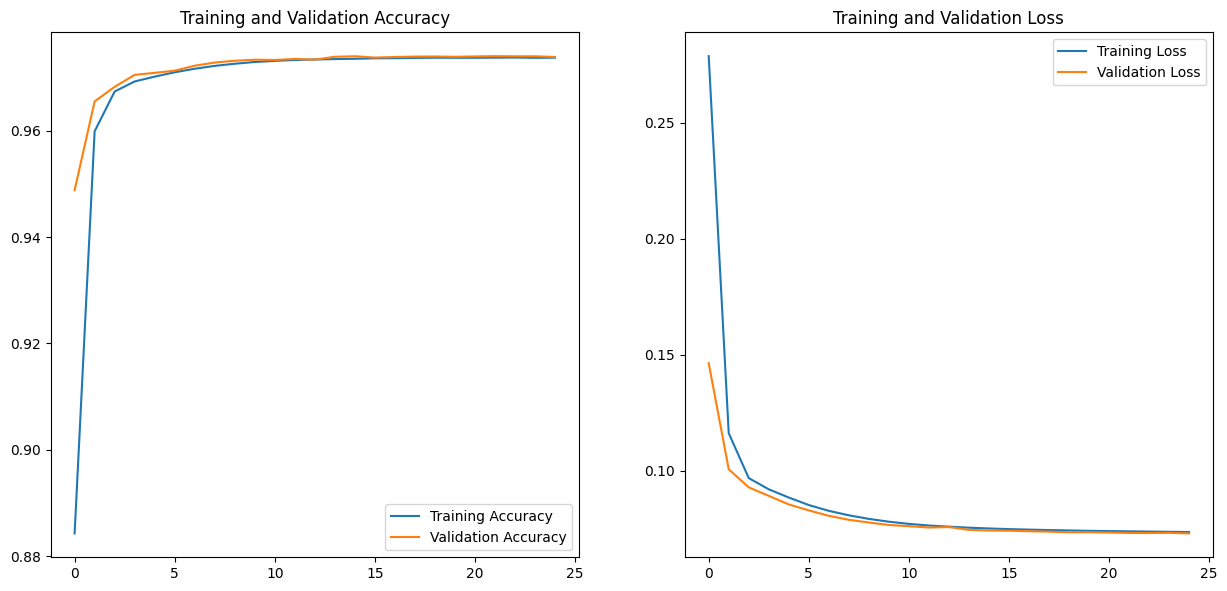

In [16]:
acc = mlp_model.history.history['accuracy']
val_acc = mlp_model.history.history['val_accuracy']
loss = mlp_model.history.history['loss']
val_loss = mlp_model.history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Using the test data, let’s display some metrics!

In [17]:
# Calculate and print accuracy score
y_mlp_predictions = mlp_model.predict(X_test[:, 2:X_test.shape[1]])
# Convert probabilities to class labels based on threshold
threshold = 0.5
y_mlp_predictions = np.where(y_mlp_predictions >= threshold, 1, 0)

print('Model accuracy: {0:0.4f}'.format(accuracy_score(y_test, y_mlp_predictions)))
print("Accuracy on test data \n", classification_report(y_test, y_mlp_predictions, target_names=CATEGORIES))


33041/33041 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step
Model accuracy: 0.9739
Accuracy on test data 
               precision    recall  f1-score   support

       Roofs       0.98      0.98      0.98    675608
  Vegetation       0.96      0.97      0.96    381694

    accuracy                           0.97   1057302
   macro avg       0.97      0.97      0.97   1057302
weighted avg       0.97      0.97      0.97   1057302



Let’s display the confusion matrix!

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert probabilities to class labels based on the threshold
threshold = 0.5
y_mlp_predictions_binary = np.where(y_mlp_predictions >= threshold, 1, 0)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_mlp_predictions_binary)

In [19]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    '''
    This function helps plot the confusion matrix.
    '''
    # Calculate accuracy and misclassification rate
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    # Set default colormap
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    # Normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Display the matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    # Set tick labels if provided
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    # Add numbers inside the cells
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.1%}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,3}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nAccuracy={:0.1%}; Misclass={:0.1%}'.format(accuracy, misclass))
    plt.show()


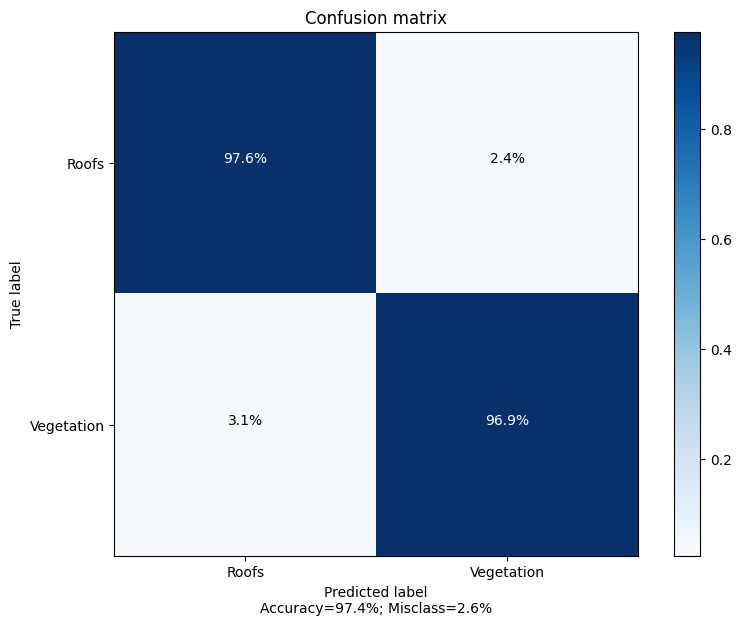

In [20]:
cm_display2 = plot_confusion_matrix(cm, target_names=CATEGORIES)

## 4.) Let's apply the MLP model on a larger point cloud!

Let's download the point cloud!

In [21]:
!gdown -q --fuzzy https://drive.google.com/file/d/1c8T5TZ8HqfqaGfDo-M0DXJJk9BeV30Uw/view?usp=drive_link -O barnag_pointcloud_with_fts.las

In [22]:
# Downloaded point cloud
pc_fnm = 'barnag_pointcloud_with_fts.las'
# Defining the model
model_filename = 'mlp_model.pickle'
# Folder for saving results
new_folder = pc_fnm[:-4] + '_predicted_classes'

Preparing

In [23]:
pc2np = pc_features2np(pc_fnm, custom_extra_dim_names)
X_features = pc2np[:,2:pc2np.shape[1]]
X_features = MinMaxScaler().fit_transform(X_features)

Loading and applying the trained model

In [24]:
model = pickle.load(open(model_filename, 'rb'))
y_predict = model.predict(X_features)
threshold = 0.5
y_predict = np.where(y_predict >= threshold, 1, 0)

115115/115115 ━━━━━━━━━━━━━━━━━━━━ 168s 1ms/step


Exporting the results

In [25]:
# Define variables for export
xyz = pc2np[:,0:3]
colors = pc2np[:,3:6]
classes = np.unique(y_predict)
labels = y_predict

# Number of points per class
unique_labels, unique_label_counts = np.unique(y_predict, return_counts=True)
for label, count in zip(unique_labels, unique_label_counts):
    print(f'Number of elements in class {label}: {count}')

# Create folder for export
if os.path.isdir(new_folder):
    shutil.rmtree(new_folder, ignore_errors=True)
    os.mkdir(new_folder)
else:
    os.mkdir(new_folder)

# Save point clouds by class
for class_n in classes:
    row_ix = np.where(labels == class_n)
    xyz_class = xyz[row_ix[0],:]
    color_class = colors[row_ix[0],:]
    pc_class = o3d.geometry.PointCloud()
    pc_class.points = o3d.utility.Vector3dVector(xyz_class)
    pc_class.colors = o3d.utility.Vector3dVector(color_class/255)
    if class_n >= 0:
        if not o3d.io.write_point_cloud(os.path.join(new_folder, f'class_{str(class_n)}.ply'), pc_class):  # Export ply
            print(f'Failed to save cluster {class_n}')
    else:
        if not o3d.io.write_point_cloud(os.path.join(new_folder, 'noise.ply'), pc_class): # export noise
            print(f'Failed to save cluster {class_n}')


Number of elements in class 0: 2017686
Number of elements in class 1: 1665978


Let's download the results and check it in CloudCompare!

![](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/mlp_result.png?raw=true)

### References

- https://learn.microsoft.com/hu-hu/azure/machine-learning/concept-deep-learning-vs-machine-learning?view=azureml-api-2

- http://dx.doi.org/10.30921/GK.75.2023.5.2
